In [1]:
import torch
import MiniFL as mfl
import math

In [2]:
STEPS = 100
SIZE = 200

In [3]:
CORELLATED_GAMMAS = {
    10:  {0.0: 2, 0.5: 4, 1.0: 8},
    100: {0.0: 2, 0.5: 4, 1.0: 8},
    1000: {0.0: 2, 0.5: 4, 1.0: 8},
}

In [4]:
def measure_all(seed, num_clients, noise_lambda, steps=STEPS):
    def get_task():
        return mfl.tasks.create_worst_case_tridiagonal_quadratics(
            num_clients=num_clients,
            size=SIZE,
            noise_lambda=noise_lambda,
        )
    
    # eden_gamma_multiplier = 8
    # eden_metrics = None
    # while True:
    #     master, clients = mfl.algorithms.get_ef21_master_and_clients(
    #         get_task(),
    #         compressors=[mfl.compressors.EdenContractiveCompressor(SIZE, bits=1, seed=1 + 7*seed + i) for i in range(num_clients)],
    #         gamma_multiplier=eden_gamma_multiplier,
    #     )
    #     next_eden_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)
    #     if math.isnan(next_eden_metrics[-1].value) or next_eden_metrics[-1].value > next_eden_metrics[len(next_eden_metrics)//2].value:
    #         print(f"{num_clients=}, {noise_lambda=} diverged at {eden_gamma_multiplier=}")
    #         break
    #     else:
    #         eden_metrics = next_eden_metrics
    #         eden_gamma_multiplier *= 2

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        get_task(),
        compressors=[mfl.compressors.EdenContractiveCompressor(SIZE, bits=1, seed=5 + 9*num_clients + 11 * int(100 * noise_lambda)) for _ in range(num_clients)],
        gamma_multiplier=CORELLATED_GAMMAS[num_clients][noise_lambda],
    )
    correlated_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        get_task(),
        compressors=[mfl.compressors.EdenContractiveCompressor(SIZE, bits=1, seed=1 + 7*seed + i + 9*num_clients + 11 * int(100 * noise_lambda)) for i in range(num_clients)],
        gamma_multiplier=8,
    )
    decorrelated_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)
        

    return correlated_metrics, decorrelated_metrics

In [5]:
import numpy as np

NOISE_LAMBDAS = (0,0.5,1.0)
NUM_CLIENTS = (10, 100, 1000)

CORRELATED_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}
DECORRELATED_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}

for i, num_clients in enumerate(NUM_CLIENTS):
    for j, noise_lambda in enumerate(NOISE_LAMBDAS):
        print(f"Measuring {num_clients=} {noise_lambda=}")
        correlated_metrics, decorrelated_metrics = measure_all(seed=101*i + j, num_clients=num_clients, noise_lambda=noise_lambda)
        CORRELATED_METRICS[num_clients][noise_lambda] = correlated_metrics
        DECORRELATED_METRICS[num_clients][noise_lambda] = decorrelated_metrics

Measuring num_clients=10 noise_lambda=0


100%|██████████| 100/100 [00:02<00:00, 45.66it/s]


Measuring num_clients=10 noise_lambda=0.5


100%|██████████| 100/100 [00:01<00:00, 51.49it/s]


Measuring num_clients=10 noise_lambda=1.0


100%|██████████| 100/100 [00:01<00:00, 60.24it/s]


Measuring num_clients=100 noise_lambda=0


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Measuring num_clients=100 noise_lambda=0.5


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Measuring num_clients=100 noise_lambda=1.0


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Measuring num_clients=1000 noise_lambda=0


KeyError: 1000

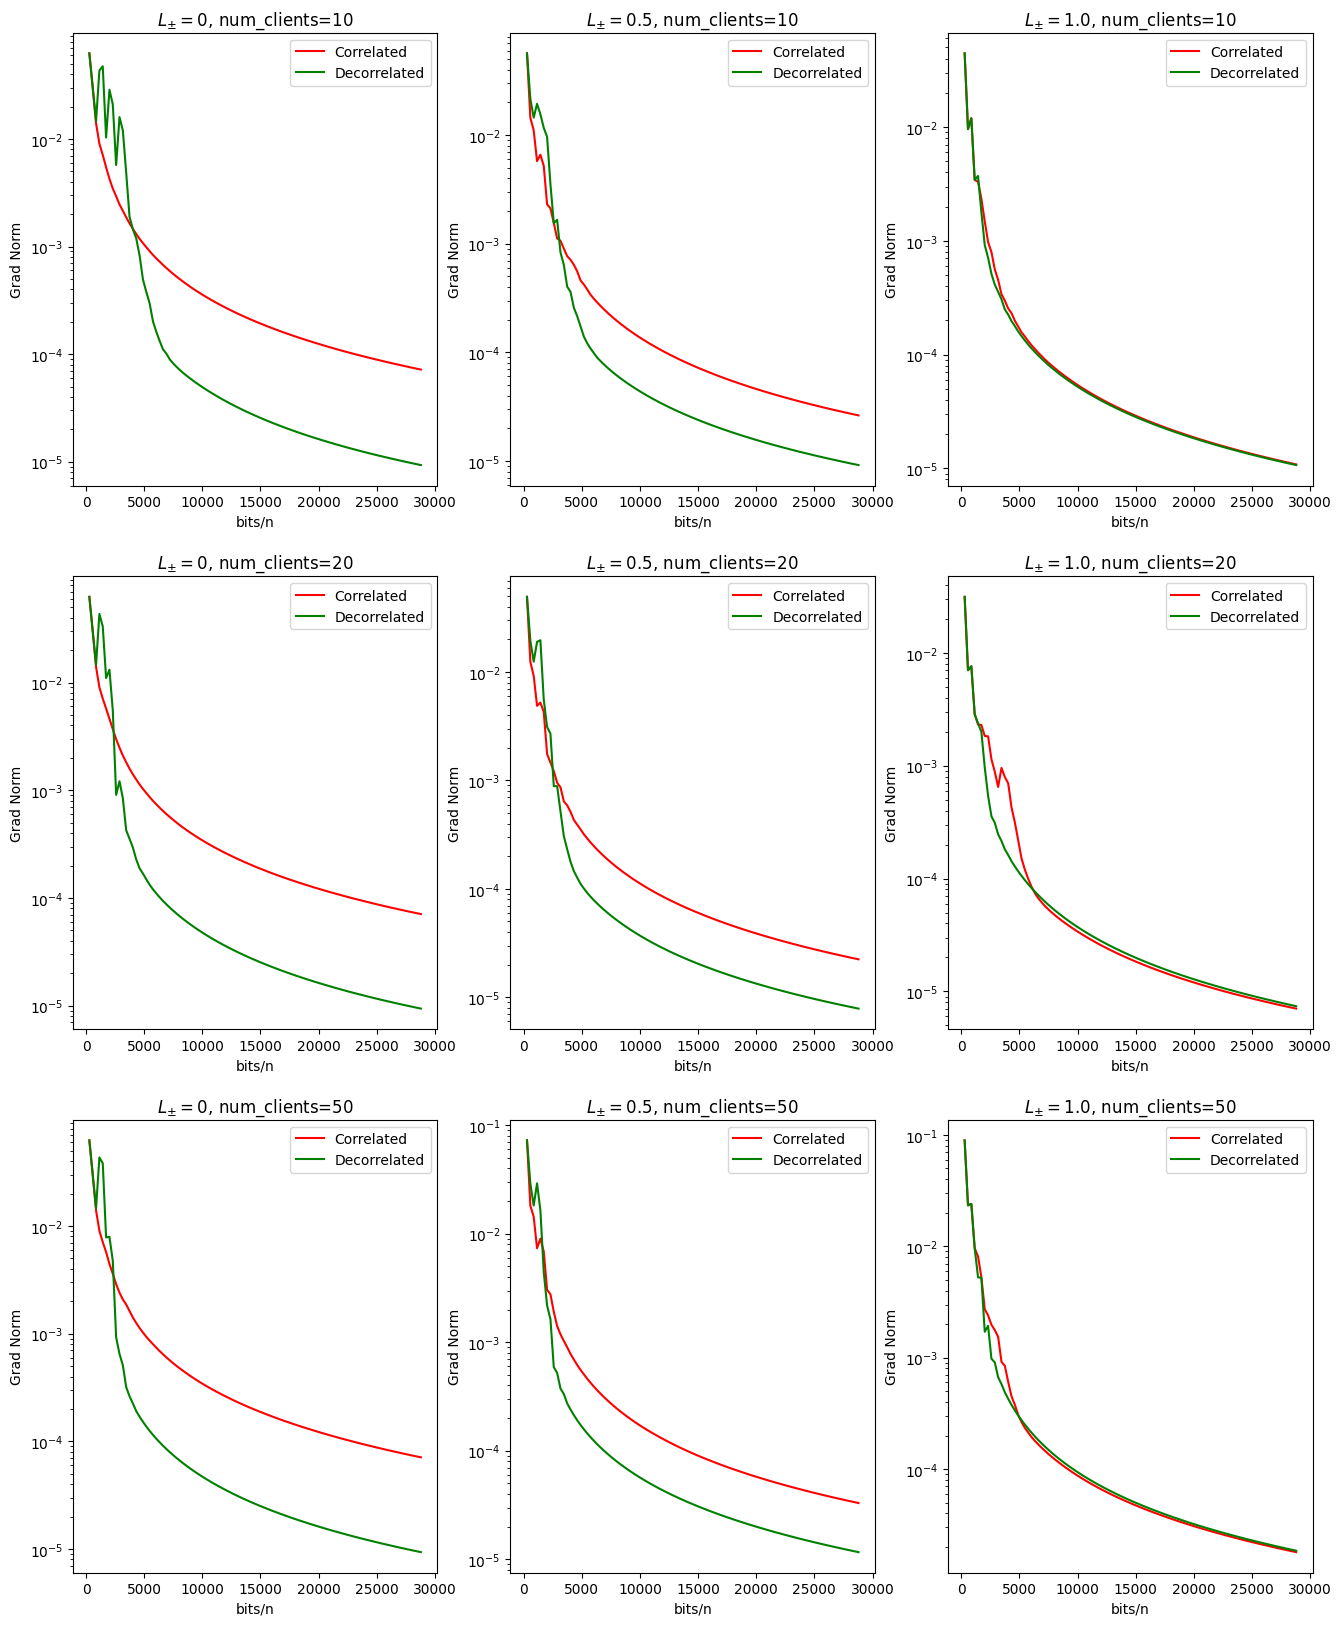

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(16, 20))

for i, num_clients in enumerate(NUM_CLIENTS):
    for j, noise_lambda in enumerate(NOISE_LAMBDAS):
        ax = axes[i][j]
        ax.set_title(r"$L_{\pm}=$" + str(noise_lambda) + ", " + f"{num_clients=}")

        try:
            ax.plot([metrics.total_bits_received/num_clients for metrics in CORRELATED_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in CORRELATED_METRICS[num_clients][noise_lambda]], color="red", label="Correlated")
            ax.plot([metrics.total_bits_received/num_clients for metrics in DECORRELATED_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in DECORRELATED_METRICS[num_clients][noise_lambda]], color="green", label="Decorrelated")
        except KeyError:
            pass

        ax.set_yscale("log")
        # ax.set_xlim(0, 1.5*1e6)
        # ax.set_ylim(0.005, 3)
        ax.set_xlabel("bits/n")
        ax.set_ylabel("Grad Norm")
        ax.legend()
